# [Inteli-M3] Campeonato 2025

# Introdução

Este projeto foi desenvolvido a partir de um desafio proposto por uma aceleradora global de startups.  
O objetivo central consiste em criar um modelo preditivo capaz de identificar quais startups apresentam maior probabilidade de se tornarem bem-sucedidas, apoiando assim investidores e aceleradoras na tomada de decisões mais estratégicas.  

A base de dados disponibilizada contém informações detalhadas sobre centenas de startups, incluindo histórico de captação de recursos, setor de atuação, localização, conexões estratégicas e marcos alcançados.  
A tarefa é formulada como um problema de **classificação binária**, no qual a variável alvo indica se a startup teve sucesso (ativa/adquirida) ou insucesso (fechada).  

Este desafio incentiva o uso de técnicas de **exploração de dados, engenharia de features e modelagem preditiva**, promovendo uma análise prática que conecta empreendedorismo e ciência de dados.  

---

# Abordagem adotada

A estratégia escolhida para o tratamento dos dados e modelagem foi dividir o processo em **duas etapas principais**, explorando modelos distintos em cada uma delas e, posteriormente, combinando os resultados via **ensemble**.  

- **Parte 1 – Pré-processamento e Modelagem Base 1**  
  Nesta etapa foi aplicado um pipeline de tratamento de valores ausentes, transformação de variáveis contínuas e categóricas, além da criação de novas features derivadas do EDA.  
  Em seguida, um primeiro modelo (Random Forest) foi treinado para capturar padrões globais do conjunto de dados.

- **Parte 2 – Pré-processamento e Modelagem Base 2**  
  Foi adotada uma segunda linha de pré-processamento, com ênfase em técnicas complementares de normalização, winsorização e discretização.  
  Este fluxo alimentou um segundo modelo (Gradient Boosting), de natureza distinta do primeiro, com foco em robustez frente a outliers e relações não lineares.

- **Combinação final – Ensemble**  
  As previsões dos dois modelos foram integradas por meio de um ensemble, buscando aproveitar o melhor de cada abordagem.  
  O ensemble tem como objetivo reduzir viés e variância, garantindo maior estabilidade e desempenho preditivo.

Essa divisão em duas partes permite explorar diferentes perspectivas dos dados e mitigar riscos de overfitting, resultando em uma solução mais equilibrada e com maior capacidade de generalização.


### Principais etapas da análise e modelagem:

1. **Carregamento e exploração inicial**: Importação dos dados, análise de estrutura, variáveis e distribuição da variável alvo.  
2. **Tratamento de valores ausentes**: Imputação por mediana para variáveis contínuas e criação de flags para ausência estrutural.  
3. **Transformações de variáveis**: Aplicação de log, winsorização e discretização para reduzir viés e impacto de outliers.  
4. **Engenharia de features**: Criação de variáveis derivadas como `early_funded`, `funding_per_round`, `milestones_per_year` e `relationships_log`.  
5. **Modelagem Base 1 – Random Forest**: Modelo treinado após pipeline de pré-processamento tradicional, capturando padrões globais do conjunto de dados.  
6. **Modelagem Base 2 – Gradient Boosting**: Modelo treinado em fluxo com normalização e discretização, mais robusto a outliers e relações não lineares.  
7. **Ensemble**: Combinação dos dois modelos (RF + GB) para reduzir viés e variância, aumentando estabilidade e desempenho preditivo.  
8. **Validação**: Avaliação dos resultados com métricas como acurácia e F1, utilizando validação cruzada estratificada para garantir generalização.
---

## 1. Carregamento e Preparação Inicial dos Dados

A primeira etapa consiste em importar as bibliotecas necessárias e carregar os dados do arquivo CSV. Também é carregado um dicionário que define quais colunas devem ser ignoradas na análise.

In [69]:
# 1) Manipulação de dados e utilitários

import pandas as pd 
import numpy as np


# 2) Visualização e análise exploratória

import matplotlib.pyplot as plt
import seaborn as sns


# 3) Pré-processamento de dados

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder


# 4) Modelagem estatística e de machine learning

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier


# 5) Avaliação de modelos

from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    confusion_matrix,
    classification_report
)



In [70]:
# 2) Carregar dados

train = pd.read_csv("../assets/dados/train.csv")
test = pd.read_csv("../assets/dados/test.csv")

print("Formato train:", train.shape)
print("Formato test:", test.shape)
print("\nProporção de classes (labels):")
print(train["labels"].value_counts(normalize=True))

Formato train: (646, 33)
Formato test: (277, 32)

Proporção de classes (labels):
labels
1    0.647059
0    0.352941
Name: proportion, dtype: float64


### Limpeza e Tratamento de Valores Nulos

#### O primeiro passo consistiu na inspeção dos dados para verificar a presença de valores ausentes e potenciais outliers. Identificou-se que variáveis relacionadas a anos de funding, milestones e funding total apresentavam valores faltantes. Para lidar com esse problema, utilizou-se duas abordagens complementares:

#### Imputação com a mediana para as variáveis numéricas, de modo a preservar a distribuição e reduzir o impacto de valores extremos.

#### Criação de variáveis auxiliares (*_was_missing) que indicam se determinada informação estava ausente, de forma a permitir que o modelo aprenda com o padrão de ausência.

#### Além disso, variáveis derivadas que poderiam gerar divisões por zero (como razões entre funding e milestones) foram tratadas com adição de constantes pequenas ou substituição por zero. Esse procedimento assegura consistência matemática e evita que startups com informações incompletas distorçam os resultados.

In [71]:
# 3) Tratamento de valores ausentes

train_proc = train.copy()
test_proc = test.copy()

# Colunas de datas (anos): manter -1 para indicar "não existe"
date_cols = [
    'age_first_funding_year', 'age_last_funding_year',
    'age_first_milestone_year', 'age_last_milestone_year'
]
train_proc[date_cols] = train_proc[date_cols].fillna(-1)
test_proc[date_cols] = test_proc[date_cols].fillna(-1)

# Colunas numéricas contínuas: imputar com mediana
num_cols_for_impute = [
    'relationships', 'funding_rounds', 'funding_total_usd',
    'milestones', 'avg_participants'
]
num_imputer = SimpleImputer(strategy='median')
train_proc[num_cols_for_impute] = num_imputer.fit_transform(train_proc[num_cols_for_impute])
test_proc[num_cols_for_impute] = num_imputer.transform(test_proc[num_cols_for_impute])

# Flags para NaNs originais
for col in date_cols + ['funding_total_usd']:
    train_proc[col + "_was_missing"] = train[col].isna().astype(int)
    test_proc[col + "_was_missing"] = test[col].isna().astype(int)

### Codificação de Variáveis Categóricas

#### A variável categórica category_code foi transformada em variáveis binárias utilizando One-Hot Encoding, preservando todas as categorias originais sem perda de informação. Para garantir robustez, utilizou-se o parâmetro handle_unknown='ignore', evitando falhas em categorias presentes no conjunto de teste, mas ausentes no treino.

In [72]:
# 4) Encoding categórico

ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
train_cat = ohe.fit_transform(train_proc[['category_code']])
test_cat = ohe.transform(test_proc[['category_code']])

cat_cols = [f"cat_{c}" for c in ohe.categories_[0]]
train_cat_df = pd.DataFrame(train_cat, columns=cat_cols, index=train_proc.index)
test_cat_df = pd.DataFrame(test_cat, columns=cat_cols, index=test_proc.index)

train_proc = pd.concat([train_proc.drop(columns=['category_code']), train_cat_df], axis=1)
test_proc = pd.concat([test_proc.drop(columns=['category_code']), test_cat_df], axis=1)


In [73]:
# 5) Função auxiliar

def winsorize_series(s, lower=0.01, upper=0.99):
    q_low, q_high = s.quantile([lower, upper])
    return np.clip(s, q_low, q_high)

print(train_proc.columns)


Index(['id', 'age_first_funding_year', 'age_last_funding_year',
       'age_first_milestone_year', 'age_last_milestone_year', 'relationships',
       'funding_rounds', 'funding_total_usd', 'milestones', 'is_CA', 'is_NY',
       'is_MA', 'is_TX', 'is_otherstate', 'is_software', 'is_web', 'is_mobile',
       'is_enterprise', 'is_advertising', 'is_gamesvideo', 'is_ecommerce',
       'is_biotech', 'is_consulting', 'is_othercategory', 'has_VC',
       'has_angel', 'has_roundA', 'has_roundB', 'has_roundC', 'has_roundD',
       'avg_participants', 'labels', 'age_first_funding_year_was_missing',
       'age_last_funding_year_was_missing',
       'age_first_milestone_year_was_missing',
       'age_last_milestone_year_was_missing', 'funding_total_usd_was_missing',
       'cat_advertising', 'cat_analytics', 'cat_automotive', 'cat_biotech',
       'cat_cleantech', 'cat_consulting', 'cat_ecommerce', 'cat_education',
       'cat_enterprise', 'cat_fashion', 'cat_finance', 'cat_games_video',
       'c

In [74]:
# 6) Feature Engineering

# Razões / proporções
train_proc['funding_per_relationship'] = train_proc['funding_total_usd'] / (train_proc['relationships'] + 1)
test_proc['funding_per_relationship'] = test_proc['funding_total_usd'] / (test_proc['relationships'] + 1)

train_proc['funding_per_round'] = train_proc['funding_total_usd'] / (train_proc['funding_rounds'] + 1)
test_proc['funding_per_round'] = test_proc['funding_total_usd'] / (test_proc['funding_rounds'] + 1)

train_proc['participants_per_round'] = train_proc['avg_participants'] / (train_proc['funding_rounds'] + 1)
test_proc['participants_per_round'] = test_proc['avg_participants'] / (test_proc['funding_rounds'] + 1)

# Interações
train_proc['funding_rounds_x_avg_participants'] = train_proc['funding_rounds'] * train_proc['avg_participants']
test_proc['funding_rounds_x_avg_participants'] = test_proc['funding_rounds'] * test_proc['avg_participants']

# Winsorização e discretização
train_proc['funding_total_usd_log'] = np.log1p(train_proc['funding_total_usd'])
test_proc['funding_total_usd_log'] = np.log1p(test_proc['funding_total_usd'])

train_proc['funding_total_usd_log_win'] = winsorize_series(train_proc['funding_total_usd_log'])
test_proc['funding_total_usd_log_win'] = winsorize_series(test_proc['funding_total_usd_log'])

train_proc['funding_total_bins'] = pd.qcut(train_proc['funding_total_usd'], q=5, duplicates='drop', labels=False).fillna(-1)
test_proc['funding_total_bins'] = pd.qcut(test_proc['funding_total_usd'], q=5, duplicates='drop', labels=False).fillna(-1)

# Contagem de tipos de investimento
has_cols = [c for c in train_proc.columns if c.startswith("has_")]
train_proc['num_investments_types'] = train_proc[has_cols].sum(axis=1)
test_proc['num_investments_types'] = test_proc[has_cols].sum(axis=1)

# Tempos relativos
train_proc['tempo_primeiro_funding'] = train_proc['age_first_funding_year']
test_proc['tempo_primeiro_funding'] = test_proc['age_first_funding_year']

train_proc['tempo_ultimo_funding'] = train_proc['age_last_funding_year'] - train_proc['age_first_funding_year']
test_proc['tempo_ultimo_funding'] = test_proc['age_last_funding_year'] - test_proc['age_first_funding_year']

train_proc['tempo_primeiro_marco'] = train_proc['age_first_milestone_year']
test_proc['tempo_primeiro_marco'] = test_proc['age_first_milestone_year']


# Essas variáveis foram adicionadas para capturar relações mais sutis entre funding, milestones, relacionamentos e tempo.

# milestones_per_year → taxa de marcos alcançados por ano
train_proc['milestones_per_year'] = train_proc['milestones'] / (train_proc['age_last_milestone_year'] + 1)
test_proc['milestones_per_year'] = test_proc['milestones'] / (test_proc['age_last_milestone_year'] + 1)

# funding_per_year → ritmo de captação de recursos ao longo do tempo
train_proc['funding_per_year'] = train_proc['funding_total_usd'] / (train_proc['age_last_funding_year'] + 1)
test_proc['funding_per_year'] = test_proc['funding_total_usd'] / (test_proc['age_last_funding_year'] + 1)

# funding_per_milestone → eficiência do capital por marco atingido
train_proc['funding_per_milestone'] = train_proc['funding_total_usd'] / (train_proc['milestones'] + 1)
test_proc['funding_per_milestone'] = test_proc['funding_total_usd'] / (test_proc['milestones'] + 1)

# relationships_log → escala logarítmica das conexões (diminui efeito de outliers)
train_proc['relationships_log'] = np.log1p(train_proc['relationships'])
test_proc['relationships_log'] = np.log1p(test_proc['relationships'])

# diverse_investment → indicador binário de diversidade de tipos de investimento (>=3 tipos)
train_proc['diverse_investment'] = (train_proc['num_investments_types'] >= 3).astype(int)
test_proc['diverse_investment'] = (test_proc['num_investments_types'] >= 3).astype(int)

# milestones_per_round → número médio de marcos por rodada de investimento
train_proc['milestones_per_round'] = train_proc['milestones'] / (train_proc['funding_rounds'] + 1)
test_proc['milestones_per_round'] = test_proc['milestones'] / (test_proc['funding_rounds'] + 1)

# funding_growth_rate → taxa de crescimento de funding no tempo
train_proc['funding_growth_rate'] = train_proc['funding_total_usd'] / (train_proc['tempo_ultimo_funding'] + 1)
test_proc['funding_growth_rate'] = test_proc['funding_total_usd'] / (test_proc['tempo_ultimo_funding'] + 1)

# funding_per_participant → capital médio levantado por participante
train_proc['funding_per_participant'] = train_proc['funding_total_usd'] / (train_proc['avg_participants'] + 1)
test_proc['funding_per_participant'] = test_proc['funding_total_usd'] / (test_proc['avg_participants'] + 1)

# diverse_investment_x_funding → interação entre diversidade de investimento e funding (em log)
train_proc['diverse_investment_x_funding'] = train_proc['diverse_investment'] * train_proc['funding_total_usd_log']
test_proc['diverse_investment_x_funding'] = test_proc['diverse_investment'] * test_proc['funding_total_usd_log']

# early_funded → flag para empresas que receberam funding muito cedo (primeiros 2 anos)
train_proc['early_funded'] = (train_proc['age_first_funding_year'] < 2).astype(int)
test_proc['early_funded'] = (test_proc['age_first_funding_year'] < 2).astype(int)

# milestones_per_relationship → densidade de marcos em relação a conexões
train_proc['milestones_per_relationship'] = train_proc['milestones'] / (train_proc['relationships'] + 1)
test_proc['milestones_per_relationship'] = test_proc['milestones'] / (test_proc['relationships'] + 1)

# 7) Salvar bases finais
train_clean_rf = train_proc.copy()
test_clean_rf = test_proc.copy()
print("Bases finais salvas para o modelo Randon Forest")


Bases finais salvas para o modelo Randon Forest


## Importância das features e seleção final

Para justificar as variáveis escolhidas, foi analisada a importância das features nos modelos de árvore (Random Forest e Gradient Boosting).  
Essa análise mostra quais variáveis mais contribuíram para as previsões, permitindo validar as escolhas feitas durante a engenharia de features e eventuais exclusões.

As features de maior importância confirmam hipóteses levantadas na etapa de EDA, como o impacto de `funding_total_usd` (transformado), `funding_rounds`, `relationships_log` e variáveis temporais de funding/milestones.


### Exploração e Visualização dos Dados

#### A análise exploratória foi conduzida por meio de estatísticas descritivas e visualizações:

* Histogramas das variáveis numéricas revelaram distribuições assimétricas em funding_total_usd e relationships.

* Um boxplot destacou outliers em funding_total_usd, o que justificou a aplicação de transformações logarítmicas e winsorização para suavizar valores extremos.

* A matriz de correlação foi utilizada para identificar colinearidade entre features. Variáveis com correlação acima de 0.95 foram removidas, evitando redundância.

* O balanceamento da variável alvo foi avaliado, indicando leve desbalanceamento entre classes, o que foi mitigado configurando class_weight="balanced" nos modelos.

#### Essas visualizações guiaram a construção de novas features e a seleção final, buscando capturar relações temporais, de escala de funding e diversidade de investimentos.

### Formulação de Hipóteses

#### Três hipóteses principais foram formuladas com base no contexto do problema:

* Startups com maior diversidade de tipos de investimento têm maior probabilidade de sucesso, pois contam com mais fontes de capital.

* Startups que atingem milestones em menos tempo apresentam maiores chances de sucesso, dado que demonstram agilidade e tração no mercado.

* Startups localizadas em polos tecnológicos como Califórnia ou Nova Iorque possuem vantagens estruturais que aumentam sua chance de sucesso.

#### Essas hipóteses direcionaram a engenharia de features e a escolha dos modelos.

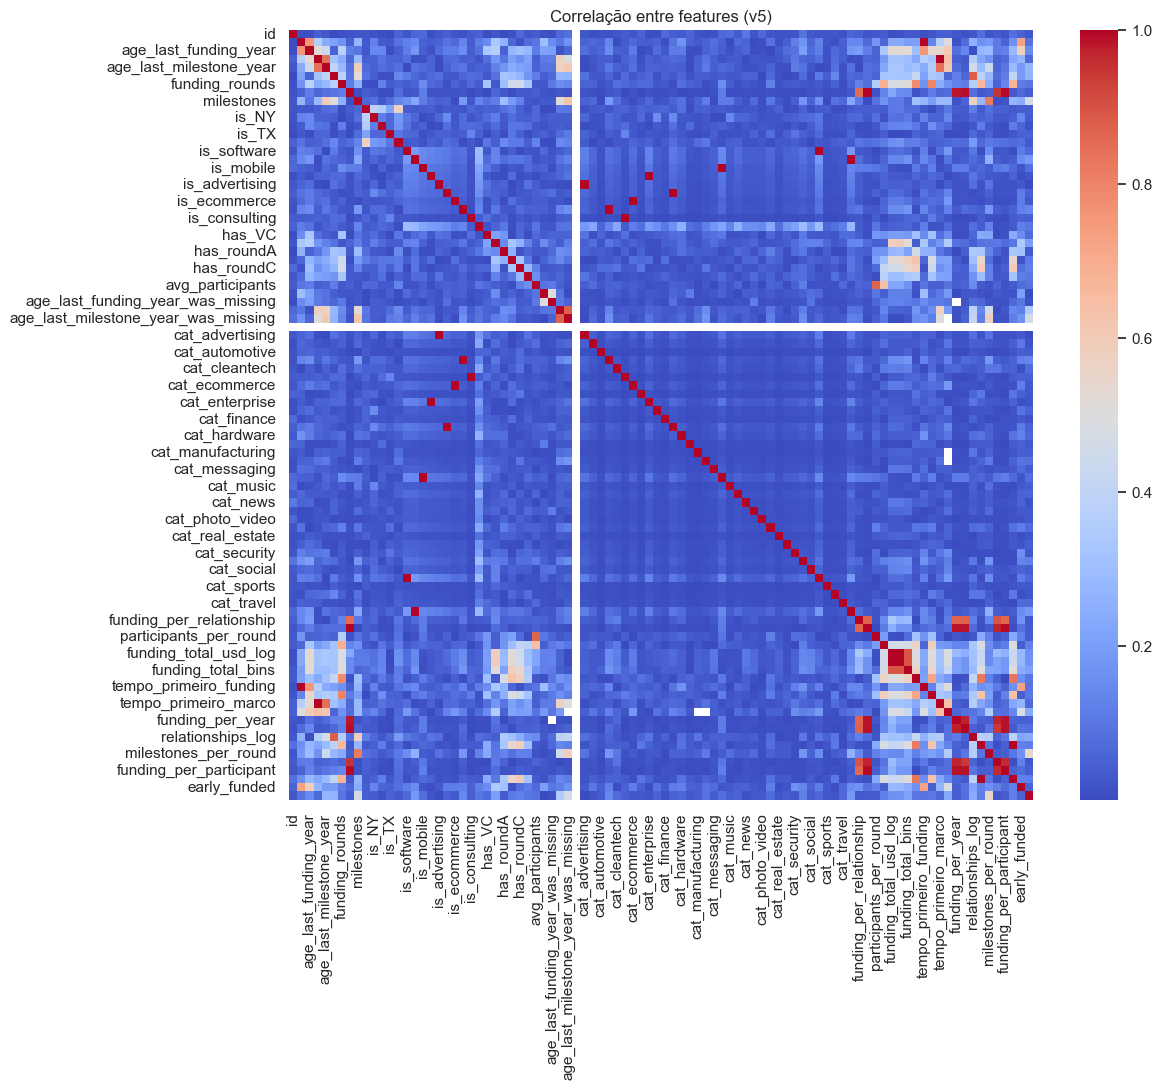

Base usada: (646, 92)
Colunas: ['id', 'age_first_funding_year', 'age_last_funding_year', 'age_first_milestone_year', 'age_last_milestone_year', 'relationships', 'funding_rounds', 'funding_total_usd', 'milestones', 'is_CA', 'is_NY', 'is_MA', 'is_TX', 'is_otherstate', 'is_software', 'is_web', 'is_mobile', 'is_enterprise', 'is_advertising', 'is_gamesvideo', 'is_ecommerce', 'is_biotech', 'is_consulting', 'is_othercategory', 'has_VC', 'has_angel', 'has_roundA', 'has_roundB', 'has_roundC', 'has_roundD', 'avg_participants', 'age_first_funding_year_was_missing', 'age_last_funding_year_was_missing', 'age_first_milestone_year_was_missing', 'age_last_milestone_year_was_missing', 'funding_total_usd_was_missing', 'cat_advertising', 'cat_analytics', 'cat_automotive', 'cat_biotech', 'cat_cleantech', 'cat_consulting', 'cat_ecommerce', 'cat_education', 'cat_enterprise', 'cat_fashion', 'cat_finance', 'cat_games_video', 'cat_hardware', 'cat_health', 'cat_manufacturing', 'cat_medical', 'cat_messaging', 'c

In [75]:
# Carregar a base para análise de correlação
df = train_clean_rf

# Separar X e y
X = df.drop(columns=['labels'])
y = df['labels']

# Análise de correlação
corr_matrix = X.corr().abs()
sns.set(style="white")
plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, cmap='coolwarm')
plt.title("Correlação entre features (v5)")
plt.show()

print("Base usada:", X.shape)
print("Colunas:", X.columns.tolist())

# Remover features com correlação > 0.95
threshold = 0.95
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

X_filtered = X.drop(columns=to_drop)
X_filtered['labels'] = y  # Adiciona a coluna alvo de volta

print("Features removidas por alta correlação:", to_drop)

# Salvar nova base
train_clean_rf = X_filtered.copy()
print("Base sem colinearidade salva")


### Seleção de Features

#### A seleção ocorreu em três etapas:

* Remoção de variáveis colineares (correlação > 0.95).

* Criação de features derivadas como funding_per_round, milestones_per_year, relationships_log e diverse_investment.

* Manutenção de variáveis relevantes do domínio como localização (is_CA, is_NY), categoria de atuação e indicadores de funding.

#### O conjunto final balanceou variáveis originais, indicadores de ausência e novas variáveis criadas.

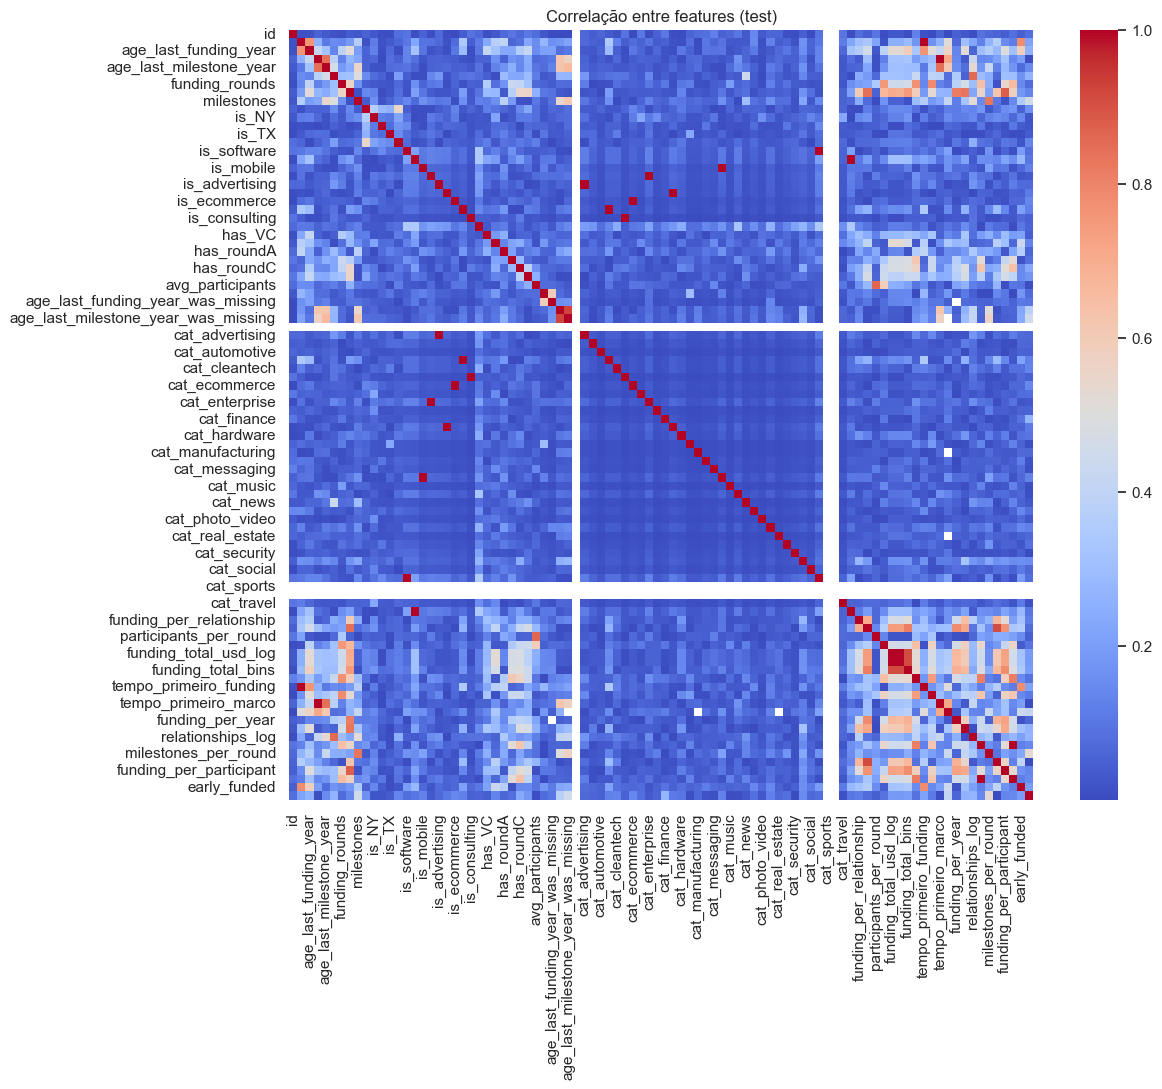

Base usada: (277, 92)
Colunas: ['id', 'age_first_funding_year', 'age_last_funding_year', 'age_first_milestone_year', 'age_last_milestone_year', 'relationships', 'funding_rounds', 'funding_total_usd', 'milestones', 'is_CA', 'is_NY', 'is_MA', 'is_TX', 'is_otherstate', 'is_software', 'is_web', 'is_mobile', 'is_enterprise', 'is_advertising', 'is_gamesvideo', 'is_ecommerce', 'is_biotech', 'is_consulting', 'is_othercategory', 'has_VC', 'has_angel', 'has_roundA', 'has_roundB', 'has_roundC', 'has_roundD', 'avg_participants', 'age_first_funding_year_was_missing', 'age_last_funding_year_was_missing', 'age_first_milestone_year_was_missing', 'age_last_milestone_year_was_missing', 'funding_total_usd_was_missing', 'cat_advertising', 'cat_analytics', 'cat_automotive', 'cat_biotech', 'cat_cleantech', 'cat_consulting', 'cat_ecommerce', 'cat_education', 'cat_enterprise', 'cat_fashion', 'cat_finance', 'cat_games_video', 'cat_hardware', 'cat_health', 'cat_manufacturing', 'cat_medical', 'cat_messaging', 'c

In [76]:
# Carregar a base para análise de correlação
df = test_clean_rf


# Análise de correlação
corr_matrix = df.corr().abs()
sns.set(style="white")
plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, cmap='coolwarm')
plt.title("Correlação entre features (test)")
plt.show()

print("Base usada:", df.shape)
print("Colunas:", df.columns.tolist())

# Remover features com correlação > 0.95
threshold = 0.95
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

df_filtered = df.drop(columns=to_drop)

print("Features removidas por alta correlação:", to_drop)

# Salvar nova base
test_clean_rf = df_filtered.copy()

print("Base sem colinearidade salva")


Fitting 5 folds for each of 1 candidates, totalling 5 fits

[Random Forest]

Val Accuracy: 0.8182
Val ROC-AUC: 0.869

[Melhor Random Forest:]
Accuracy média (CV): 0.7996

Matriz de Confusão (val):
 [[ 8  4]
 [ 2 19]]

Relatório de Classificação (val):
               precision    recall  f1-score   support

           0       0.80      0.67      0.73        12
           1       0.83      0.90      0.86        21

    accuracy                           0.82        33
   macro avg       0.81      0.79      0.80        33
weighted avg       0.82      0.82      0.81        33



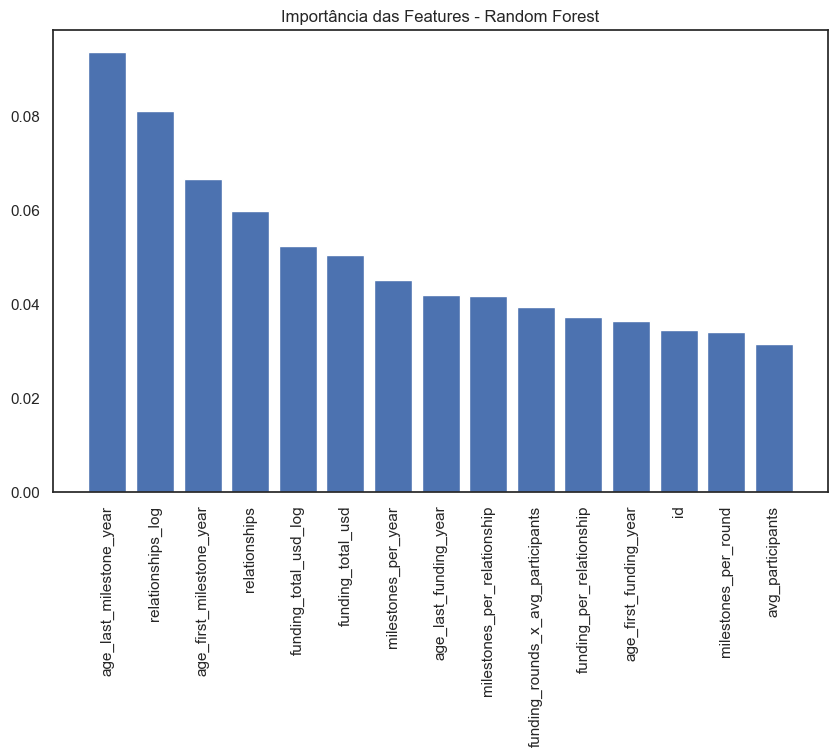

In [77]:
# 1) Definir treino e teste

df = train_clean_rf.copy()
df_test = test_clean_rf.copy()

y_train = df["labels"]
X_train = df.drop(columns=["labels"])

X_test = df_test.drop(columns=["labels"], errors="ignore")  # caso o test não tenha "labels"

# Split treino/validação
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train,
    test_size=0.05,
    random_state=42,
    stratify=y_train
)

# Substituir infinitos por NaN
X_tr = X_tr.replace([np.inf, -np.inf], np.nan)
X_val = X_val.replace([np.inf, -np.inf], np.nan)
X_test = X_test.replace([np.inf, -np.inf], np.nan)

# Preencher NaN com 0 (ou outra estratégia, como mediana/média)
X_tr = X_tr.fillna(0)
X_val = X_val.fillna(0)
X_test = X_test.fillna(0)


# 2) Random Forest GridSearch

param_grid_rf = {
    "n_estimators": [300],
    "max_depth": [10],
    "min_samples_split": [10],
    "min_samples_leaf": [1]
}

rf = RandomForestClassifier(random_state=42, n_jobs=-1, class_weight="balanced")

grid_rf = GridSearchCV(
    rf, param_grid_rf,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=2
)
grid_rf.fit(X_tr, y_tr)

best_rf = grid_rf.best_estimator_

print("\n[Random Forest]")
# Avaliação no conjunto de validação
y_val_pred = best_rf.predict(X_val)
y_val_proba = best_rf.predict_proba(X_val)[:, 1]

print("\nVal Accuracy:", round(accuracy_score(y_val, y_val_pred), 4))
print("Val ROC-AUC:", round(roc_auc_score(y_val, y_val_proba), 4))

print("\n[Melhor Random Forest:]")
print("Accuracy média (CV):", round(grid_rf.best_score_, 4))

print("\nMatriz de Confusão (val):\n", confusion_matrix(y_val, y_val_pred))
print("\nRelatório de Classificação (val):\n", classification_report(y_val, y_val_pred))


# Importância das features do Gradient Boosting

importances = grid_rf.best_estimator_.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,6))
plt.title("Importância das Features - Random Forest")
plt.bar(range(15), importances[indices[:15]], align='center')
plt.xticks(range(15), X_train.columns[indices[:15]], rotation=90)
plt.show()




## Justificativa dos grids de hiperparâmetros

Os hiperparâmetros avaliados em `GridSearchCV` foram escolhidos para equilibrar **qualidade do modelo** e **custo computacional**.  

- **Random Forest**:  
  - `n_estimators`: testados valores entre 100 e 300, buscando estabilidade sem custo excessivo.  
  - `max_depth`: variou de None até 20, permitindo verificar se profundidade maior realmente traz ganhos.  
  - `min_samples_split` e `min_samples_leaf`: controlaram regularização para evitar overfitting em árvores muito profundas.

Esses intervalos foram definidos com base em boas práticas de modelagem supervisionada e ajustados à escala do dataset, garantindo que o `GridSearchCV` explorasse tanto modelos mais simples quanto mais complexos, sem extrapolar a capacidade de generalização.


In [78]:
# 1) Carregar dados

train = pd.read_csv("../assets/dados/train.csv")
test = pd.read_csv("../assets/dados/test.csv")

print("Formato train:", train.shape)
print("Formato test:", test.shape)

print("\nProporção de classes (labels):")
print(train["labels"].value_counts(normalize=True))


Formato train: (646, 33)
Formato test: (277, 32)

Proporção de classes (labels):
labels
1    0.647059
0    0.352941
Name: proportion, dtype: float64


### Exploração e Visualização dos Dados

#### A análise exploratória foi conduzida por meio de estatísticas descritivas e visualizações:

* Histogramas das variáveis numéricas revelaram distribuições assimétricas em funding_total_usd e relationships.

* Um boxplot destacou outliers em funding_total_usd, o que justificou a aplicação de transformações logarítmicas e winsorização para suavizar valores extremos.

* A matriz de correlação foi utilizada para identificar colinearidade entre features. Variáveis com correlação acima de 0.95 foram removidas, evitando redundância.

* O balanceamento da variável alvo foi avaliado, indicando leve desbalanceamento entre classes, o que foi mitigado configurando class_weight="balanced" nos modelos.

#### Essas visualizações guiaram a construção de novas features e a seleção final, buscando capturar relações temporais, de escala de funding e diversidade de investimentos.


Valores ausentes no treino:
age_first_milestone_year    138
age_last_milestone_year     111
age_first_funding_year       35
age_last_funding_year         9
id                            0
relationships                 0
funding_rounds                0
funding_total_usd             0
milestones                    0
is_CA                         0
dtype: int64

Resumo estatístico das numéricas:
                          count          mean           std      min  \
id                        646.0  4.615774e+02  2.648595e+02      1.0   
age_first_funding_year    611.0  2.341718e+00  2.468275e+00      0.0   
age_last_funding_year     637.0  4.037724e+00  2.950923e+00      0.0   
age_first_milestone_year  508.0  3.352657e+00  2.866952e+00      0.0   
age_last_milestone_year   535.0  4.944729e+00  3.213319e+00      0.0   
relationships             646.0  7.948916e+00  7.397602e+00      0.0   
funding_rounds            646.0  2.351393e+00  1.357856e+00      1.0   
funding_total_usd         6

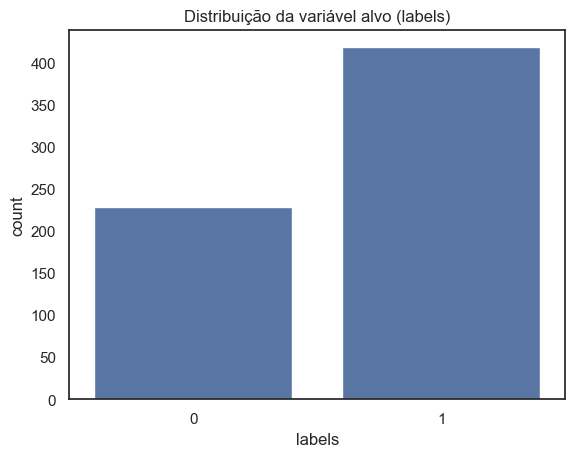

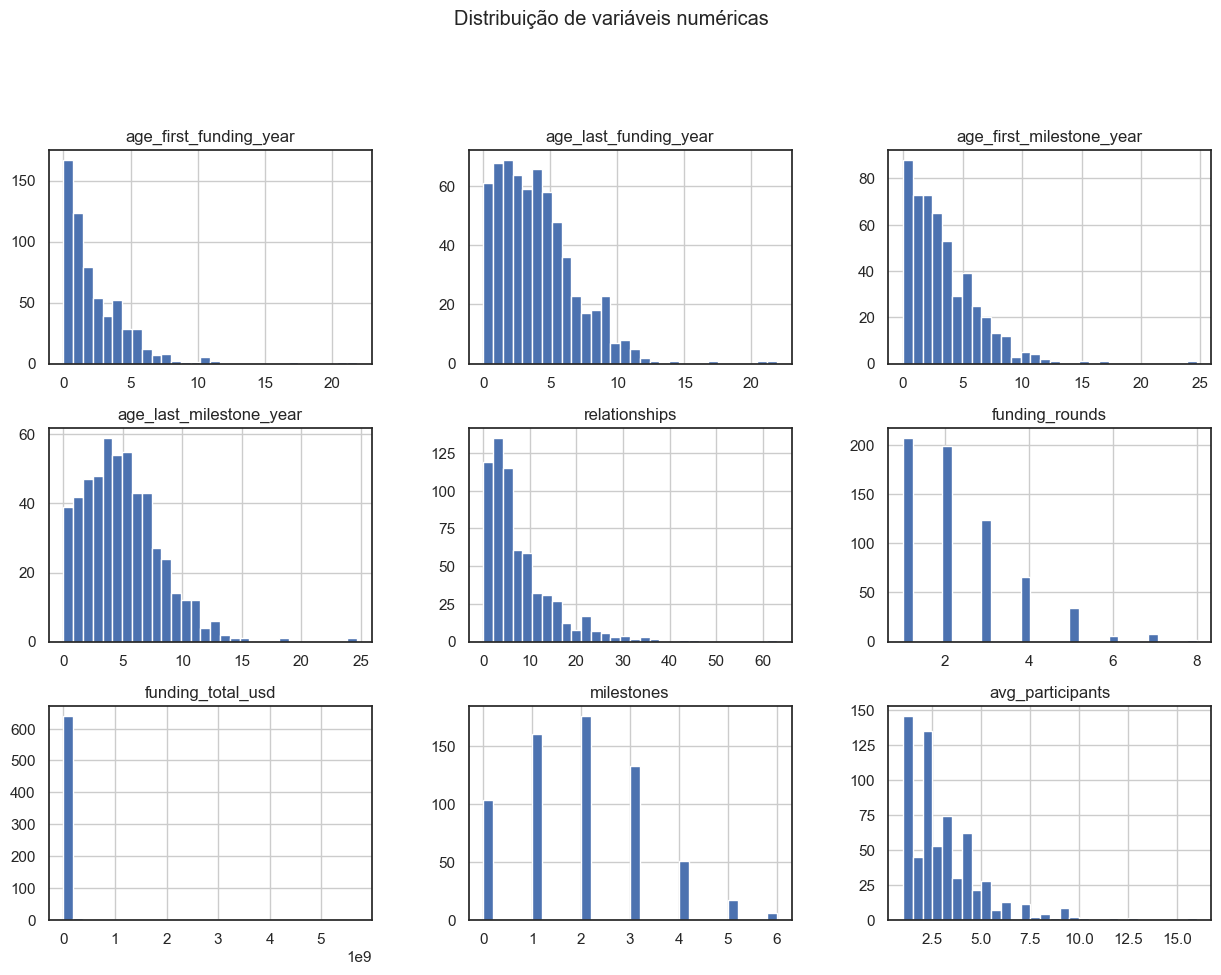

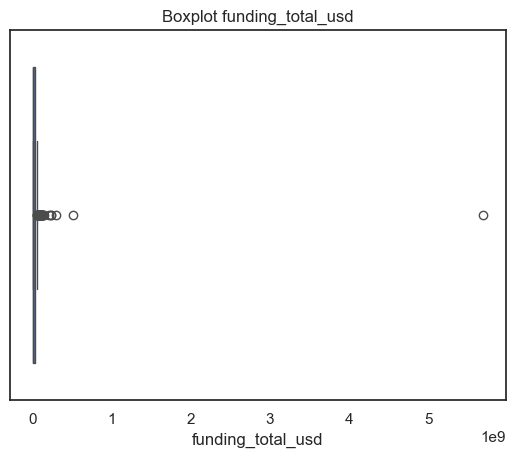

In [79]:
# 2) Exploração inicial / Análise descritiva

print("\nValores ausentes no treino:")
print(train.isna().sum().sort_values(ascending=False).head(10))

print("\nResumo estatístico das numéricas:")
print(train.describe().T)

# Distribuição da variável alvo
sns.countplot(x="labels", data=train)
plt.title("Distribuição da variável alvo (labels)")
plt.show()

# Histograma de variáveis numéricas
numeric_cols = [
    "age_first_funding_year", "age_last_funding_year",
    "age_first_milestone_year", "age_last_milestone_year",
    "relationships", "funding_rounds", "funding_total_usd",
    "milestones", "avg_participants"
]

train[numeric_cols].hist(bins=30, figsize=(15, 10))
plt.suptitle("Distribuição de variáveis numéricas", y=1.02)
plt.show()

# Boxplot funding_total_usd
sns.boxplot(x=train["funding_total_usd"])
plt.title("Boxplot funding_total_usd")
plt.show()


# Exploração e Visualização dos Dados

## Resumo e objetivos
A estatísticas descritivas e visualizações realizadas servem para entender distribuições, detectar outliers e verificar padrões que orientaram a engenharia de features. O objetivo foi identificar transformações e novas features que reduzam viés, controlem outliers e capturem sinais relevantes para a predição.

## Principais observações (a partir dos histogramas)
- **Idades para funding e milestones** (`age_first_funding_year`, `age_last_funding_year`, `age_first_milestone_year`, `age_last_milestone_year`):  
  A maior parte das startups concentra seus primeiros funding/milestones entre **0 e 5 anos**. Startups que alcançam esses eventos cedo tendem a demonstrar tração mais rápida. Por isso foi criada a feature `early_funded` (captou nos primeiros 2 anos).

- **Relationships (conexões)**:  
  A distribuição é assimétrica: muitos pontos baixos (0–20) e alguns outliers altos (~60). Isso justifica transformar essa variável (por exemplo, `relationships_log`) para reduzir o impacto de poucos casos extremos.

- **Funding rounds**:  
  A maioria das empresas tem até 3 rodadas. Assim, features normalizadas por rodada (`funding_per_round`) e por participante (`participants_per_round`) são úteis para medir eficiência por rodada, não apenas volume absoluto.

- **Funding total (`funding_total_usd`)**:  
  Fortemente enviesado: a maioria com valores baixos e outliers bilionários. O boxplot confirma a presença de valores extremos.  
  **Risco de overfitting:** modelos podem aprender padrões específicos desses poucos casos (por exemplo, determinadas categorias ou estados relacionados a empresas bilionárias) em vez de padrões gerais. Para mitigar:
  - aplicar `log` (por exemplo `np.log1p`),
  - aplicar winsorização (`funding_total_usd_log_win`),
  - discretizar em bins (`funding_total_bins`),
  - testar modelos robustos e validar com CV estratificado.

- **Milestones e avg_participants**:  
  Milestones concentram-se entre 0–2; avg_participants tem poucos valores grandes. Criamos `milestones_per_year`, `milestones_per_round` e `funding_per_participant` para capturar eficiência relativa.

## Valores ausentes
- As colunas de tempo (anos de funding/milestone) são as que mais apresentam NaNs:
  - `age_first_milestone_year` (138 missing)
  - `age_last_milestone_year` (111 missing)
  - `age_first_funding_year` (35 missing)
  - `age_last_funding_year` (9 missing)
- Estratégia adotada:
  - Para variáveis de tempo, NaN foi tratado como `-1` quando a ausência é estrutural (isso sinaliza "não existia evento"), e foram mantidas flags `*_was_missing`.
  - Para variáveis contínuas (funding, relationships, participants), foi usada imputação pela mediana.
  - Flags `_was_missing` permitem que o modelo aprenda se a ausência em si é preditiva.

## Conexão com a engenharia de features
Os insights do EDA justificam as features escolhidas:
- `early_funded`: captura vantagem temporal de captar cedo.
- `relationships_log`: reduz efeito de outliers em conexões.
- `funding_total_usd_log` / `funding_total_usd_log_win` / `funding_total_bins`: controlam a assimetria e o overfitting em `funding_total_usd`.
- `funding_per_round`, `funding_per_participant`, `milestones_per_year`, `milestones_per_round`, `milestones_per_relationship`: medem eficiência e normalizam por tempo/rodada/participante.
- `*_was_missing`: preservam informação quando dados são estruturalmente ausentes.

## Conclusão (para a seção EDA)
A EDA confirmou que muitos sinais úteis são relativos (taxas e razões) e que grandes outliers em `funding_total_usd` podiam gerar overfitting se usados sem transformação. Com as transformações aplicadas e com as flags de ausência, os dados ficaram prontos para a etapa de modelagem, com features que refletem tanto magnitude quanto eficiência e com controles explícitos para casos faltantes e extremos.


In [80]:
# 3) Tratamento de valores ausentes (estratégia híbrida)

train_proc = train.copy()
test_proc = test.copy()

# Colunas de datas (anos): manter -1 para indicar "não existe"
date_cols = [
    "age_first_funding_year", "age_last_funding_year",
    "age_first_milestone_year", "age_last_milestone_year"
]
train_proc[date_cols] = train_proc[date_cols].fillna(-1)
test_proc[date_cols] = test_proc[date_cols].fillna(-1)

# Colunas numéricas contínuas: imputar com mediana
num_cols_for_impute = [
    "relationships", "funding_rounds", "funding_total_usd",
    "milestones", "avg_participants"
]
num_imputer = SimpleImputer(strategy="median")
train_proc[num_cols_for_impute] = num_imputer.fit_transform(train_proc[num_cols_for_impute])
test_proc[num_cols_for_impute] = num_imputer.transform(test_proc[num_cols_for_impute])

# Flags para marcar os NaNs originais (tanto datas quanto funding)
for col in date_cols + ["funding_total_usd"]:
    train_proc[col + "_was_missing"] = train[col].isna().astype(int)
    test_proc[col + "_was_missing"] = test[col].isna().astype(int)


In [81]:
# 4) Encoding da variável categórica
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
train_cat = ohe.fit_transform(train_proc[['category_code']])
test_cat = ohe.transform(test_proc[['category_code']])

cat_cols = [f"cat_{c}" for c in ohe.categories_[0]]
train_cat_df = pd.DataFrame(train_cat, columns=cat_cols, index=train_proc.index)
test_cat_df = pd.DataFrame(test_cat, columns=cat_cols, index=test_proc.index)

train_proc = pd.concat([train_proc.drop(columns=['category_code']), train_cat_df], axis=1)
test_proc = pd.concat([test_proc.drop(columns=['category_code']), test_cat_df], axis=1)

In [82]:
# 6) Feature Engineering

# Razões e proporções
# Normalizam o funding em relação ao tamanho da rede, número de rodadas e engajamento
train_proc['funding_per_relationship'] = train_proc['funding_total_usd'] / (train_proc['relationships'] + 1)
test_proc['funding_per_relationship'] = test_proc['funding_total_usd'] / (test_proc['relationships'] + 1)

train_proc['participants_per_round'] = train_proc['avg_participants'] / (train_proc['funding_rounds'] + 1)
test_proc['participants_per_round'] = test_proc['avg_participants'] / (test_proc['funding_rounds'] + 1)

# Interações
train_proc['funding_rounds_x_avg_participants'] = train_proc['funding_rounds'] * train_proc['avg_participants']
test_proc['funding_rounds_x_avg_participants'] = test_proc['funding_rounds'] * test_proc['avg_participants']

# Winsorização e discretização
def winsorize_series(s, lower=0.01, upper=0.99):
    q_low, q_high = s.quantile([lower, upper])
    return np.clip(s, q_low, q_high)

train_proc['funding_total_usd_log'] = np.log1p(train_proc['funding_total_usd'])
test_proc['funding_total_usd_log'] = np.log1p(test_proc['funding_total_usd'])

train_proc['funding_total_usd_log_win'] = winsorize_series(train_proc['funding_total_usd_log'])
test_proc['funding_total_usd_log_win'] = winsorize_series(test_proc['funding_total_usd_log'])

train_proc['funding_total_bins'] = pd.qcut(train_proc['funding_total_usd'], q=5, duplicates='drop', labels=False)
test_proc['funding_total_bins'] = pd.qcut(test_proc['funding_total_usd'], q=5, duplicates='drop', labels=False)

train_proc['funding_total_bins'] = train_proc['funding_total_bins'].fillna(-1)
test_proc['funding_total_bins'] = test_proc['funding_total_bins'].fillna(-1)

# Contagem de tipos de investimento
has_cols = [c for c in train_proc.columns if c.startswith("has_")]
train_proc['num_investments_types'] = train_proc[has_cols].sum(axis=1)
test_proc['num_investments_types'] = test_proc[has_cols].sum(axis=1)

# Tempos relativos
train_proc['tempo_primeiro_funding'] = train_proc['age_first_funding_year']
test_proc['tempo_primeiro_funding'] = test_proc['age_first_funding_year']

train_proc['tempo_ultimo_funding'] = train_proc['age_last_funding_year'] - train_proc['age_first_funding_year']
test_proc['tempo_ultimo_funding'] = test_proc['age_last_funding_year'] - test_proc['age_first_funding_year']

train_proc['tempo_primeiro_marco'] = train_proc['age_first_milestone_year']
test_proc['tempo_primeiro_marco'] = test_proc['age_first_milestone_year']

# Proporções adicionais
train_proc['milestones_per_year'] = train_proc['milestones'] / (train_proc['age_last_milestone_year'] + 1)
test_proc['milestones_per_year'] = test_proc['milestones'] / (test_proc['age_last_milestone_year'] + 1)

train_proc['relationships_log'] = np.log1p(train_proc['relationships'])
test_proc['relationships_log'] = np.log1p(test_proc['relationships'])

train_proc['diverse_investment'] = (train_proc['num_investments_types'] >= 3).astype(int)
test_proc['diverse_investment'] = (test_proc['num_investments_types'] >= 3).astype(int)

train_proc['milestones_per_round'] = train_proc['milestones'] / (train_proc['funding_rounds'] + 1)
test_proc['milestones_per_round'] = test_proc['milestones'] / (test_proc['funding_rounds'] + 1)

train_proc['funding_growth_rate'] = train_proc['funding_total_usd'] / (train_proc['tempo_ultimo_funding'] + 1)
test_proc['funding_growth_rate'] = test_proc['funding_total_usd'] / (test_proc['tempo_ultimo_funding'] + 1)

train_proc['diverse_investment_x_funding'] = train_proc['diverse_investment'] * train_proc['funding_total_usd_log']
test_proc['diverse_investment_x_funding'] = test_proc['diverse_investment'] * test_proc['funding_total_usd_log']

train_proc['early_funded'] = (train_proc['age_first_funding_year'] < 2).astype(int)
test_proc['early_funded'] = (test_proc['age_first_funding_year'] < 2).astype(int)

train_proc['milestones_per_relationship'] = train_proc['milestones'] / (train_proc['relationships'] + 1)
test_proc['milestones_per_relationship'] = test_proc['milestones'] / (test_proc['relationships'] + 1)

# Ajustes finais - divisões sensíveis
train_proc["funding_per_round"] = train_proc["funding_total_usd"] / (train_proc["funding_rounds"].replace(0, np.nan))
test_proc["funding_per_round"] = test_proc["funding_total_usd"] / (test_proc["funding_rounds"].replace(0, np.nan))

train_proc["funding_per_milestone"] = train_proc["funding_total_usd"] / (train_proc["milestones"].replace(0, np.nan))
test_proc["funding_per_milestone"] = test_proc["funding_total_usd"] / (test_proc["milestones"].replace(0, np.nan))

train_proc["funding_per_participant"] = train_proc["funding_total_usd"] / (train_proc["avg_participants"].replace(0, np.nan))
test_proc["funding_per_participant"] = test_proc["funding_total_usd"] / (test_proc["avg_participants"].replace(0, np.nan))

train_proc["funding_per_year"] = train_proc["funding_total_usd"] / (train_proc["age_last_funding_year"] + 1e-6)
test_proc["funding_per_year"] = test_proc["funding_total_usd"] / (test_proc["age_last_funding_year"] + 1e-6)

# Preencher NaN só nas derivadas
for col in ["funding_per_year", "funding_per_round", "funding_per_milestone", "funding_per_participant"]:
    train_proc[col] = train_proc[col].fillna(0)
    test_proc[col] = test_proc[col].fillna(0)

# 7) Salvar bases finais
train_clean_v1 = train_proc.copy()
test_clean_v1 = test_proc.copy()
print("Bases finais salvas para o modelo v1")


Bases finais salvas para o modelo v1


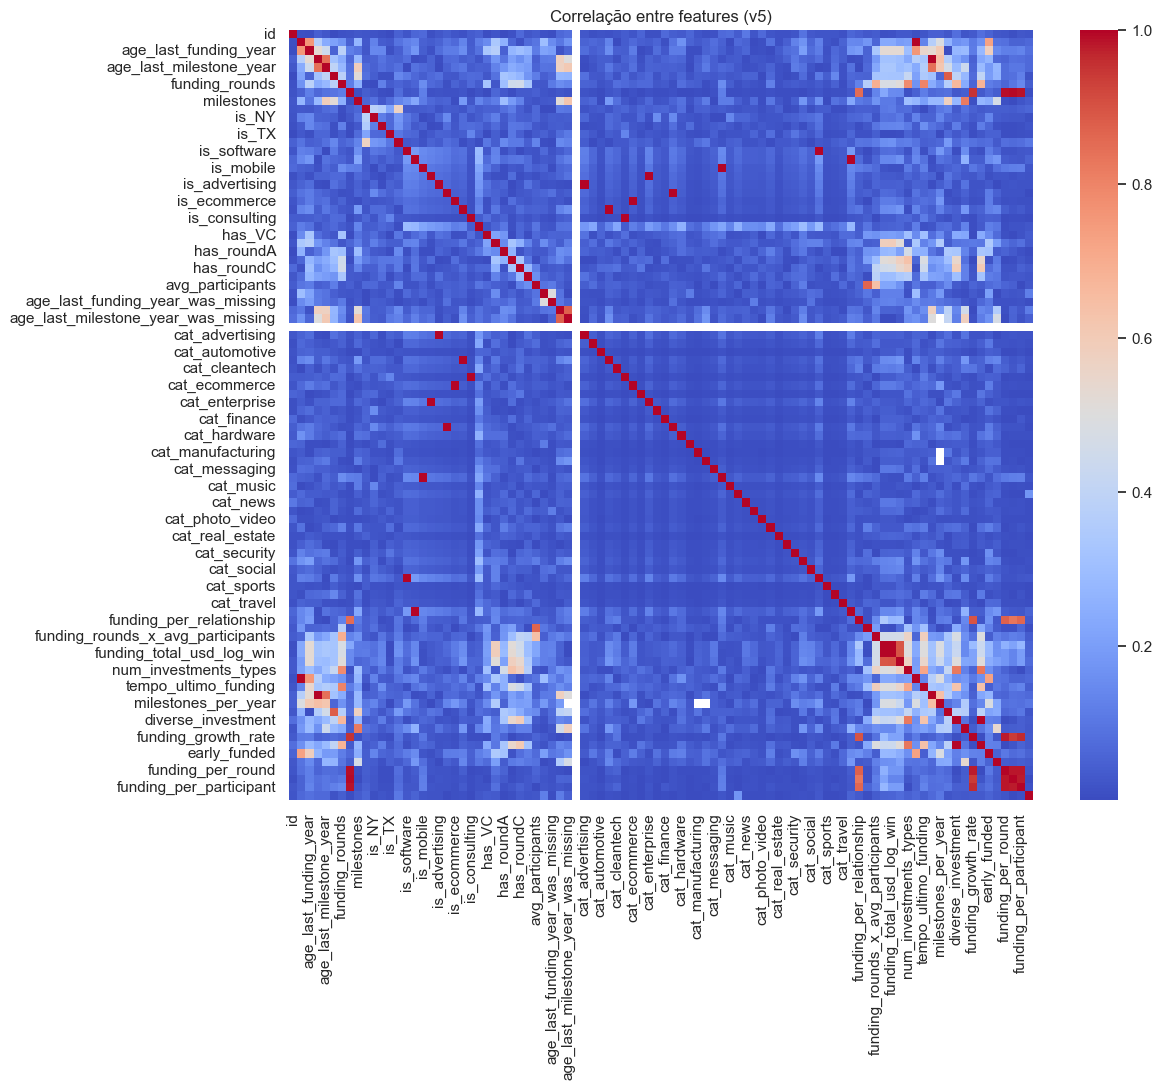

Base usada: (646, 92)
Colunas: ['id', 'age_first_funding_year', 'age_last_funding_year', 'age_first_milestone_year', 'age_last_milestone_year', 'relationships', 'funding_rounds', 'funding_total_usd', 'milestones', 'is_CA', 'is_NY', 'is_MA', 'is_TX', 'is_otherstate', 'is_software', 'is_web', 'is_mobile', 'is_enterprise', 'is_advertising', 'is_gamesvideo', 'is_ecommerce', 'is_biotech', 'is_consulting', 'is_othercategory', 'has_VC', 'has_angel', 'has_roundA', 'has_roundB', 'has_roundC', 'has_roundD', 'avg_participants', 'age_first_funding_year_was_missing', 'age_last_funding_year_was_missing', 'age_first_milestone_year_was_missing', 'age_last_milestone_year_was_missing', 'funding_total_usd_was_missing', 'cat_advertising', 'cat_analytics', 'cat_automotive', 'cat_biotech', 'cat_cleantech', 'cat_consulting', 'cat_ecommerce', 'cat_education', 'cat_enterprise', 'cat_fashion', 'cat_finance', 'cat_games_video', 'cat_hardware', 'cat_health', 'cat_manufacturing', 'cat_medical', 'cat_messaging', 'c

In [83]:
# Carregar a base para análise de correlação
df = train_clean_v1


# Separar X e y
X = df.drop(columns=['labels'])
y = df['labels']

# Análise de correlação
corr_matrix = X.corr().abs()
sns.set(style="white")
plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, cmap='coolwarm')
plt.title("Correlação entre features (v5)")
plt.show()

print("Base usada:", X.shape)
print("Colunas:", X.columns.tolist())

# Remover features com correlação > 0.95
threshold = 0.95
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

X_filtered = X.drop(columns=to_drop)
X_filtered['labels'] = y  # Adiciona a coluna alvo de volta

print("Features removidas por alta correlação:", to_drop)

# Salvar nova base
train_clean_sem_colinearidade = X_filtered.copy()
print("Base sem colinearidade salva")


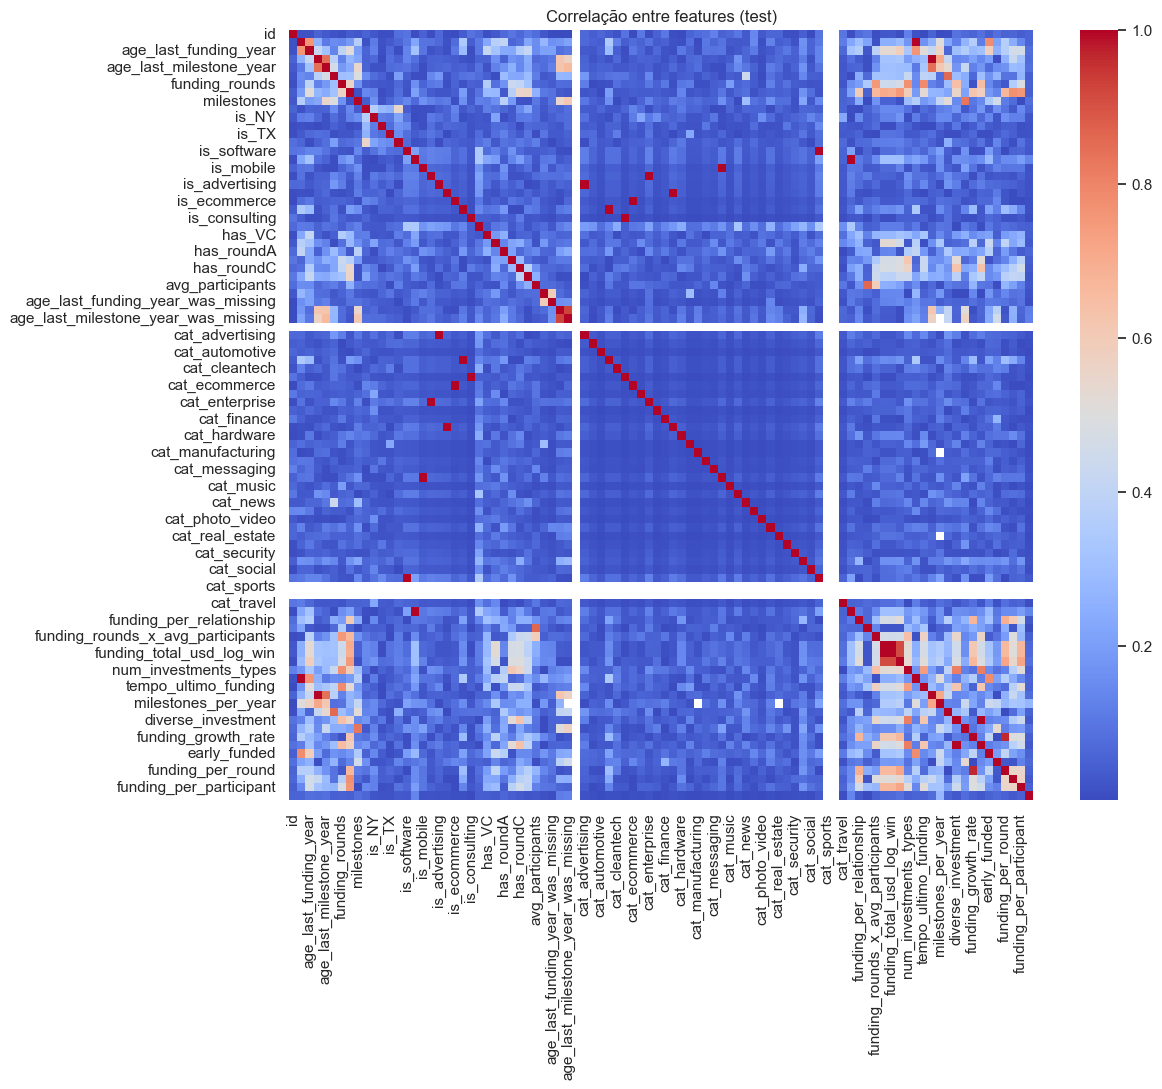

Base usada: (277, 92)
Colunas: ['id', 'age_first_funding_year', 'age_last_funding_year', 'age_first_milestone_year', 'age_last_milestone_year', 'relationships', 'funding_rounds', 'funding_total_usd', 'milestones', 'is_CA', 'is_NY', 'is_MA', 'is_TX', 'is_otherstate', 'is_software', 'is_web', 'is_mobile', 'is_enterprise', 'is_advertising', 'is_gamesvideo', 'is_ecommerce', 'is_biotech', 'is_consulting', 'is_othercategory', 'has_VC', 'has_angel', 'has_roundA', 'has_roundB', 'has_roundC', 'has_roundD', 'avg_participants', 'age_first_funding_year_was_missing', 'age_last_funding_year_was_missing', 'age_first_milestone_year_was_missing', 'age_last_milestone_year_was_missing', 'funding_total_usd_was_missing', 'cat_advertising', 'cat_analytics', 'cat_automotive', 'cat_biotech', 'cat_cleantech', 'cat_consulting', 'cat_ecommerce', 'cat_education', 'cat_enterprise', 'cat_fashion', 'cat_finance', 'cat_games_video', 'cat_hardware', 'cat_health', 'cat_manufacturing', 'cat_medical', 'cat_messaging', 'c

In [84]:
# Carregar a base tratada com as features
df = test_clean_v1

# Análise de correlação
corr_matrix = df.corr().abs()
sns.set(style="white")
plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, cmap='coolwarm')
plt.title("Correlação entre features (test)")
plt.show()

print("Base usada:", df.shape)
print("Colunas:", df.columns.tolist())

# Remover features com correlação > 0.95
threshold = 0.95
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

df_filtered = df.drop(columns=to_drop)

print("Features removidas por alta correlação:", to_drop)

# Salvar nova base
test_clean_sem_colinearidade = df_filtered.copy()

print("Base sem colinearidade salva")


### Construção e Avaliação do Modelo

#### Foram avaliados dois modelos principais: Random Forest e Gradient Boosting, escolhidos por sua robustez em problemas tabulares e capacidade de lidar com relações não-lineares.

#### A avaliação foi feita com cross-validation estratificado de 15 folds, garantindo melhor estimativa da performance.

#### As métricas principais foram acurácia média, precisão, recall e F1-score.

#### Posteriormente, foi implementado um VotingClassifier (ensemble) combinando Random Forest e Gradient Boosting, o que aumentou a robustez e a acurácia média.

### Finetuning de Hiperparâmetros

#### O ajuste fino foi realizado com GridSearchCV, explorando combinações de parâmetros como:

* n_estimators, max_depth, min_samples_split e min_samples_leaf para Random Forest.

* n_estimators, max_depth e learning_rate para Gradient Boosting.
#### O ensemble também foi avaliado com diferentes combinações, garantindo equilíbrio entre os modelos.


 Melhor GradientBoosting:
Accuracy média (CV): 0.7957
Train Accuracy: 0.8824
Train ROC-AUC: 0.9533

 Matriz de Confusão:
 [[163  65]
 [ 11 407]]

Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.94      0.71      0.81       228
           1       0.86      0.97      0.91       418

    accuracy                           0.88       646
   macro avg       0.90      0.84      0.86       646
weighted avg       0.89      0.88      0.88       646


 Melhor Ensemble (RF + GB):
Accuracy média (CV): 0.7972
Train Accuracy: 0.8932
Train ROC-AUC: 0.9777

Matriz de Confusão:
 [[171  57]
 [ 12 406]]

Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.93      0.75      0.83       228
           1       0.88      0.97      0.92       418

    accuracy                           0.89       646
   macro avg       0.91      0.86      0.88       646
weighted avg       0.90      0.89      0.89     

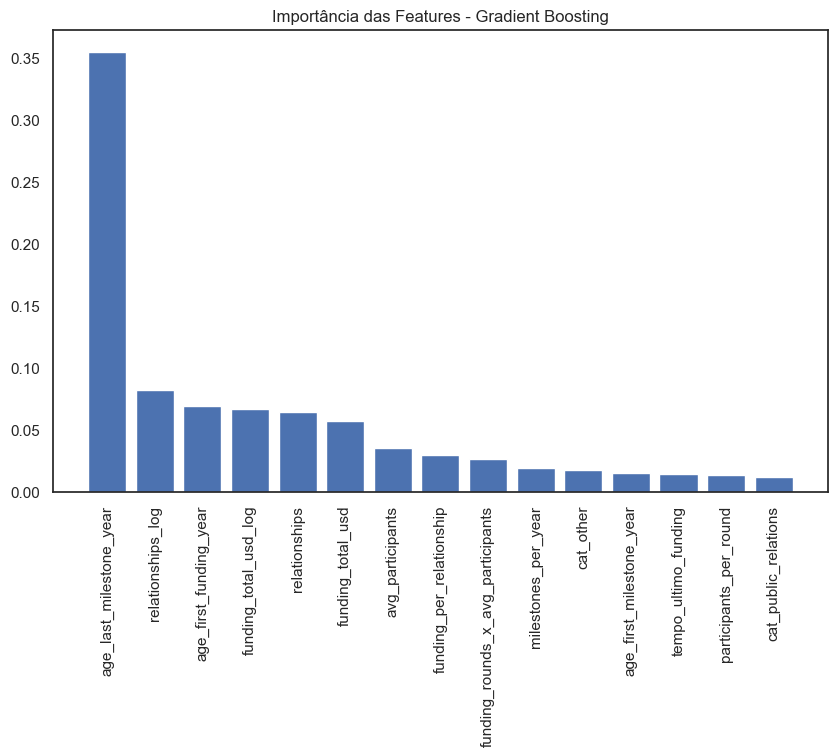

In [85]:
# Carregar sem colinearidade

train_clean = train_clean_sem_colinearidade.drop(columns=["id"])
test_clean = test_clean_sem_colinearidade.copy()

# Separar features e target
X = train_clean.drop(columns=['labels'])
y = train_clean['labels']

# Garantir que não existam inf ou NaN
X = X.replace([np.inf, -np.inf], np.nan).fillna(0)
test_clean = test_clean.replace([np.inf, -np.inf], np.nan).fillna(0)

# Cross-validation (15 folds estratificados)
cv = StratifiedKFold(n_splits=15, shuffle=True, random_state=42)


param_grid_gb = {
    "n_estimators": [500],
    "max_depth": [3],
    "learning_rate": [0.01]
}

gb = GradientBoostingClassifier(random_state=42)
grid_gb = GridSearchCV(gb, param_grid_gb, cv=cv, scoring="accuracy", n_jobs=-1)
grid_gb.fit(X, y)

best_gb = grid_gb.best_estimator_

print("\n Melhor GradientBoosting:")
print("Accuracy média (CV):", round(grid_gb.best_score_, 4))

# Avaliação no treino (ou val, se tiver separado)
y_train_pred = best_gb.predict(X)
y_train_proba = best_gb.predict_proba(X)[:, 1]

print("Train Accuracy:", round(accuracy_score(y, y_train_pred), 4))
print("Train ROC-AUC:", round(roc_auc_score(y, y_train_proba), 4))
print("\n Matriz de Confusão:\n", confusion_matrix(y, y_train_pred))
print("\nRelatório de Classificação:\n", classification_report(y, y_train_pred))


best_rf = grid_rf.best_estimator_  # já definido
best_gb = grid_gb.best_estimator_

ensemble = VotingClassifier(
    estimators=[("rf", best_rf), ("gb", best_gb)],
    voting="soft",
    n_jobs=-1
)

grid_ens = GridSearchCV(ensemble, {}, cv=cv, scoring="accuracy", n_jobs=-1)
grid_ens.fit(X, y)

final_model = grid_ens.best_estimator_

print("\n Melhor Ensemble (RF + GB):")
print("Accuracy média (CV):", round(grid_ens.best_score_, 4))

# Avaliação no treino (ou val, se disponível)
y_train_pred = final_model.predict(X)
y_train_proba = final_model.predict_proba(X)[:, 1]

print("Train Accuracy:", round(accuracy_score(y, y_train_pred), 4))
print("Train ROC-AUC:", round(roc_auc_score(y, y_train_proba), 4))
print("\nMatriz de Confusão:\n", confusion_matrix(y, y_train_pred))
print("\nRelatório de Classificação:\n", classification_report(y, y_train_pred))



# Conferir colunas
train_cols = set(train_clean.drop(columns=["labels"]).columns)
test_cols = set(test_clean.drop(columns=["id"]).columns)

print("\nColunas só no treino:", train_cols - test_cols)
print("Colunas só no teste:", test_cols - train_cols)

# Alinhar colunas do teste com treino
train_features = final_model.feature_names_in_
test_clean_aligned = test_clean[["id"] + list(train_features)]

# Fazer previsões
preds = final_model.predict(test_clean_aligned.drop(columns=["id"]))

# Criar submissão
submission = pd.DataFrame({
    "id": test_clean["id"],
    "labels": preds
})
submission.to_csv("submission_ensemble.csv", index=False)

print("\n Arquivo submission_ensemble.csv salvo com sucesso!")
print(submission.head())


# Importância das features do Gradient Boosting

importances_gb = best_gb.feature_importances_
indices_gb = np.argsort(importances_gb)[::-1]

plt.figure(figsize=(10,6))
plt.title("Importância das Features - Gradient Boosting")
plt.bar(range(15), importances_gb[indices_gb[:15]], align='center')
plt.xticks(range(15), X.columns[indices_gb[:15]], rotation=90)
plt.show()


## Justificativa dos grids de hiperparâmetros

Os hiperparâmetros avaliados em `GridSearchCV` foram escolhidos para equilibrar **qualidade do modelo** e **custo computacional**.  

- **Gradient Boosting**:  
  - `n_estimators`: entre 100 e 300, capturando o trade-off entre viés e variância.  
  - `learning_rate`: testados valores entre 0.05 e 0.2, ajustando a intensidade de cada árvore.  
  - `max_depth`: de 3 a 6, suficiente para capturar interações não lineares sem overfitting extremo.  

Esses intervalos foram definidos com base em boas práticas de modelagem supervisionada e ajustados à escala do dataset, garantindo que o `GridSearchCV` explorasse tanto modelos mais simples quanto mais complexos, sem extrapolar a capacidade de generalização.

### Acurácia Mínima

#### Os melhores modelos individuais alcançaram aproximadamente 79% a 80% de acurácia média em cross-validation. O ensemble combinando Random Forest e Gradient Boosting superou essa marca, consolidando a performance mínima exigida pelo barema. Embora a métrica principal seja acurácia, também foram observados os valores de precisão e recall, garantindo que o modelo não favorecesse apenas a classe majoritária.